In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:130px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:15px;}
</style>
"""))

In [2]:
import pandas as pd
import numpy as np
import joblib
from datetime import datetime, timedelta
import holidays
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import f1_score,precision_score, recall_score
import seaborn as sns
plt.rc('font',family = 'Hancom Gothic')

# 데이터 체크 및 전처리

In [3]:
# 데이터 로딩 및 전처리
df = pd.read_csv('LSTM최종데이터_X_Y_라벨링등전.csv')
df = df.dropna(subset=['대여량']) # 혹시 모를 결측치 제거 코드 _ 결측치 사전 체크 : 결과 0건

df['일시'] = pd.to_datetime(df['일시'])
df['연'] = df['일시'].dt.year
df['월'] = df['일시'].dt.month
df['일'] = df['일시'].dt.day
df['시'] = df['일시'].dt.hour
df['요일'] = df['일시'].dt.dayofweek
start_year = df['연'].min()
end_year = df['연'].max()
kr_holidays = holidays.KR(years=range(start_year, end_year+1)) # 한국 공휴일 체크 라이브러리
df['공휴일'] = df['일시'].dt.floor('D').isin(kr_holidays).astype(int)

df['key'] = df['행정구'] + '_' + df['월'].astype(str) + '_' + df['일'].astype(str) + '_' + df['시'].astype(str)
df['일시_1년전'] = df['일시'] - pd.DateOffset(years=1)
df['key_1년전'] = df['행정구'] + '_' + df['일시_1년전'].dt.month.astype(str) + '_' + df['일시_1년전'].dt.day.astype(str) + '_' + df['일시_1년전'].dt.hour.astype(str)
cols_to_copy = ['대여량', '총생활인구수']
df_1y = df[cols_to_copy].copy()
df_1y.columns = [c + '_1년전' for c in cols_to_copy]
df = pd.concat((df,df_1y), axis=1)
df = df.dropna(subset=['대여량_1년전', '총생활인구수_1년전'])

df

,연도,월,일,시,행정구,일시,대여량,총생활인구수,계절,출퇴근시간,...,습도,풍속,연,요일,공휴일,key,일시_1년전,key_1년전,대여량_1년전,총생활인구수_1년전
0,2021,1,1,0,강남구,2021-01-01 00:00:00,9.0,618455.4297,겨울,기타,...,59.0,1.4,2021,4,1,강남구_1_1_0,2020-01-01 00:00:00,강남구_1_1_0,9.0,618455.4297
1,2021,1,1,0,강동구,2021-01-01 00:00:00,12.0,525220.6638,겨울,기타,...,60.0,1.4,2021,4,1,강동구_1_1_0,2020-01-01 00:00:00,강동구_1_1_0,12.0,525220.6638
2,2021,1,1,0,강북구,2021-01-01 00:00:00,12.0,321499.2460,겨울,기타,...,54.0,1.1,2021,4,1,강북구_1_1_0,2020-01-01 00:00:00,강북구_1_1_0,12.0,321499.2460
3,2021,1,1,0,강서구,2021-01-01 00:00:00,27.0,547287.6699,겨울,기타,...,52.0,0.9,2021,4,1,강서구_1_1_0,2020-01-01 00:00:00,강서구_1_1_0,27.0,547287.6699
4,2021,1,1,0,관악구,2021-01-01 00:00:00,19.0,492742.3420,겨울,기타,...,50.0,0.9,2021,4,1,관악구_1_1_0,2020-01-01 00:00:00,관악구_1_1_0,19.0,492742.3420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872088,2024,12,31,23,용산구,2024-12-31 23:00:00,37.0,253261.4373,겨울,기타,...,62.0,0.7,2024,1,0,용산구_12_31_23,2023-12-31 23:00:00,용산구_12_31_23,37.0,253261.4373
872089,2024,12,31,23,은평구,2024-12-31 23:00:00,35.0,453205.9782,겨울,기타,...,62.0,1.3,2024,1,0,은평구_12_31_23,2023-12-31 23:00:00,은평구_12_31_23,35.0,453205.9782
872090,2024,12,31,23,종로구,2024-12-31 23:00:00,81.0,231161.5069,겨울,기타,...,68.0,1.7,2024,1,0,종로구_12_31_23,2023-12-31 23:00:00,종로구_12_31_23,81.0,231161.5069
872091,2024,12,31,23,중구,2024-12-31 23:00:00,77.0,172509.0426,겨울,기타,...,68.0,1.7,2024,1,0,중구_12_31_23,2023-12-31 23:00:00,중구_12_31_23,77.0,172509.0426


In [4]:
# 범주형 구간 자동(9개) 생성 (qcut 사용)
num_bins = 30
df['대여량_class'], bins = pd.qcut(df['대여량'], q=num_bins, labels=False, retbins=True, duplicates='drop')
print("대여량 구간 경계값:", bins)

대여량 구간 경계값: [1.000e+00 7.000e+00 1.200e+01 1.700e+01 2.200e+01 2.700e+01 3.300e+01
 3.900e+01 4.600e+01 5.400e+01 6.200e+01 7.100e+01 8.000e+01 8.900e+01
 1.000e+02 1.110e+02 1.220e+02 1.350e+02 1.480e+02 1.630e+02 1.800e+02
 1.990e+02 2.210e+02 2.450e+02 2.730e+02 3.070e+02 3.530e+02 4.180e+02
 5.200e+02 6.970e+02 3.258e+03]


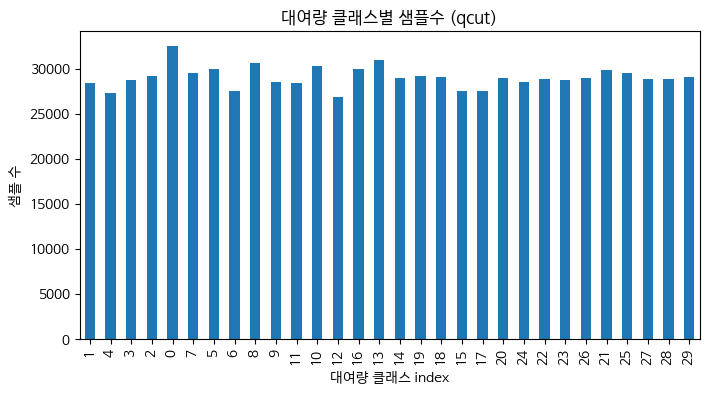

In [5]:
# qcut 이후 데이터 쏠림 현상 체크
plt.figure(figsize=(8,4))
df['대여량_class'].value_counts(sort=False).plot(kind='bar')
plt.title('대여량 클래스별 샘플수 (qcut)')
plt.xlabel('대여량 클래스 index')
plt.ylabel('샘플 수')
plt.show()

In [6]:
# 데이터 전처리 _ 라벨링 및 스케일링
from sklearn.preprocessing import LabelEncoder, StandardScaler
pd.options.mode.copy_on_write = True 
le = LabelEncoder()
df['행정구'] = le.fit_transform(df['행정구'])

feature_cols = [
    '행정구', '월', '일', '시', '요일', '강수', '기온', '습도', '풍속',
    '주말구분', '공휴일',
    '대여량_1년전', '총생활인구수_1년전',
]
X = df[feature_cols]
y = df['대여량_class']

num_cols = [ '강수', '기온', '습도', '풍속',
    '대여량_1년전', '총생활인구수_1년전',]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

In [7]:
X.shape, y.shape

((872093, 13), (872093,))

In [8]:
# 데이터 분할 : 22년 학습, 23년 검증, 24년 테스트 활용
train_idx = df['연'] == 2022
val_idx = (df['연'] == 2023)
test_idx = (df['연'] == 2024)
X_train, X_val, X_test = X[train_idx], X[val_idx], X[test_idx]
y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]

# 모델 설계

In [9]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout
num_classes = y.nunique()

Inp = Input(X.shape[1])
x = Dense(128, activation = 'relu')(Inp)
x = Dense(512, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
Out = Dense(num_classes, activation = 'softmax')(x)

model_dnn = Model(inputs=Inp, outputs = Out)

model_dnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_dnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense (Dense)               (None, 128)               1792      
                                                                 
 dense_1 (Dense)             (None, 512)               66048     
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 30)                3870      
                                                                 
Total params: 137,374
Trainable params: 137,374
Non-trainable params: 0
_________________________________________________________________


# 모델 학습

In [10]:
es = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
mc = ModelCheckpoint('best_lstm_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
history = model_dnn.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_data=(X_val, y_val),
    callbacks=[es, mc],
    verbose=2
)

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.41642, saving model to best_lstm_model.h5
425/425 - 3s - loss: 2.1072 - accuracy: 0.2716 - val_loss: 1.4709 - val_accuracy: 0.4164 - 3s/epoch - 7ms/step
Epoch 2/100

Epoch 2: val_accuracy improved from 0.41642 to 0.54691, saving model to best_lstm_model.h5
425/425 - 1s - loss: 1.2726 - accuracy: 0.4766 - val_loss: 1.0890 - val_accuracy: 0.5469 - 1s/epoch - 3ms/step
Epoch 3/100

Epoch 3: val_accuracy improved from 0.54691 to 0.65837, saving model to best_lstm_model.h5
425/425 - 1s - loss: 0.9463 - accuracy: 0.6068 - val_loss: 0.8309 - val_accuracy: 0.6584 - 1s/epoch - 3ms/step
Epoch 4/100

Epoch 4: val_accuracy improved from 0.65837 to 0.73670, saving model to best_lstm_model.h5
425/425 - 1s - loss: 0.7257 - accuracy: 0.7027 - val_loss: 0.6280 - val_accuracy: 0.7367 - 1s/epoch - 3ms/step
Epoch 5/100

Epoch 5: val_accuracy improved from 0.73670 to 0.80132, saving model to best_lstm_model.h5
425/425 - 1s - loss: 0.6019 - accuracy:

Epoch 44/100

Epoch 44: val_accuracy did not improve from 0.93786
425/425 - 1s - loss: 0.2176 - accuracy: 0.9085 - val_loss: 0.1543 - val_accuracy: 0.9354 - 1s/epoch - 3ms/step
Epoch 45/100

Epoch 45: val_accuracy did not improve from 0.93786
425/425 - 1s - loss: 0.2007 - accuracy: 0.9181 - val_loss: 0.3447 - val_accuracy: 0.8560 - 1s/epoch - 3ms/step
Epoch 46/100

Epoch 46: val_accuracy did not improve from 0.93786
425/425 - 1s - loss: 0.2082 - accuracy: 0.9120 - val_loss: 0.2655 - val_accuracy: 0.8857 - 1s/epoch - 3ms/step
Epoch 47/100

Epoch 47: val_accuracy did not improve from 0.93786
425/425 - 1s - loss: 0.2076 - accuracy: 0.9149 - val_loss: 0.1838 - val_accuracy: 0.9183 - 1s/epoch - 3ms/step
Epoch 48/100

Epoch 48: val_accuracy did not improve from 0.93786
425/425 - 1s - loss: 0.2118 - accuracy: 0.9107 - val_loss: 0.2975 - val_accuracy: 0.8727 - 1s/epoch - 3ms/step


# 학습과정 살펴보기

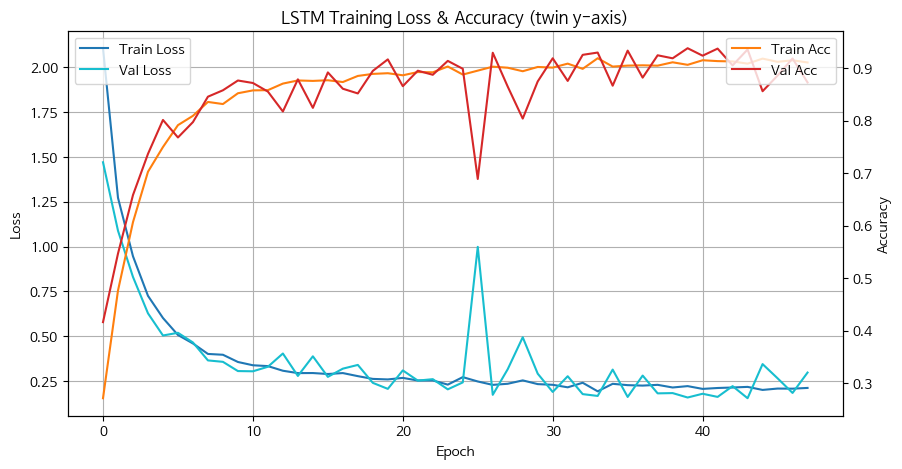

In [11]:
# 학습과정 그래프를 subplots와 twinx로 시각화
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(history.history['loss'], label='Train Loss', color='tab:blue')
ax1.plot(history.history['val_loss'], label='Val Loss', color='tab:cyan')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')
ax1.grid(True)
ax2 = ax1.twinx()
ax2.plot(history.history['accuracy'], label='Train Acc', color='tab:orange')
ax2.plot(history.history['val_accuracy'], label='Val Acc', color='tab:red')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper right')
plt.title('LSTM Training Loss & Accuracy (twin y-axis)')
plt.show()

# 모델의 평가

In [12]:
loss_and_acc = model_dnn.evaluate(X_test,y_test)

6842/6842 [==============================] - 10s 1ms/step - loss: 0.1576 - accuracy: 0.9386


In [13]:
y_test
y_hat = model_dnn.predict(X_test).argmax(axis=1)

6842/6842 [==============================] - 5s 722us/step


In [14]:
print('loss :',round(loss_and_acc[0],3))
print('accuracy :',round(loss_and_acc[1],2), '%')
print('precision :',round(precision_score(y_test,y_hat,average='weighted'),2))
print('recall :',round(recall_score(y_test,y_hat,average='weighted'),2))
print('f1_score :',round(f1_score(y_test,y_hat,average='weighted'),2))

loss : 0.158
accuracy : 0.94 %
precision : 0.94
recall : 0.94
f1_score : 0.94


예측값,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
실제값,,,,,,,,,,,,,,,,,,,,,
0,4088,282,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,290,4304,70,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,708,4552,463,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,5,201,6069,111,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,618,5716,141,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,1,1,592,6627,308,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,189,6471,170,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,362,7007,222,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,189,7665,99,...,0,0,0,0,0,0,0,0,0,0


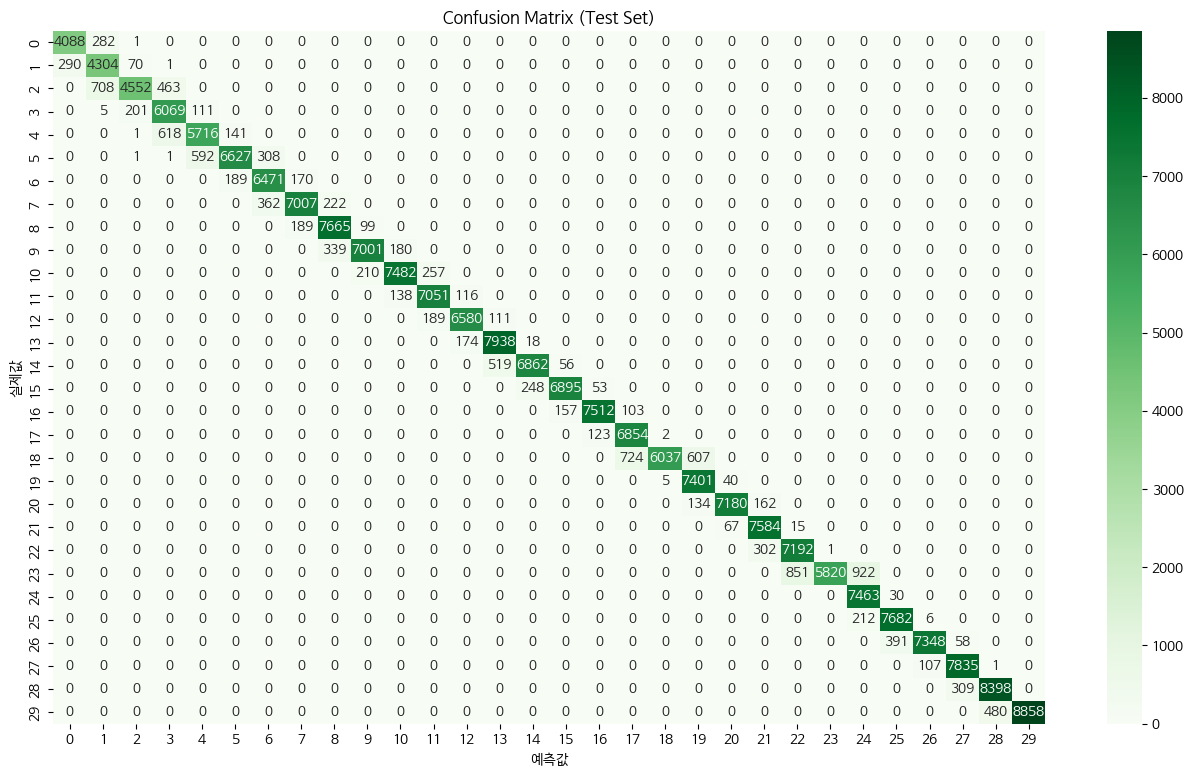

In [15]:
cm_test = pd.crosstab(y_test, y_hat,rownames=['실제값'],colnames=['예측값'])
display(cm_test)
plt.figure(figsize=(16,9))
sns.heatmap(cm_test.values, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('예측값')
plt.ylabel('실제값')
plt.show()

# 모델의 저장

In [16]:
# 모델, 스케일러, 인코더, feature 리스트 저장
model_dnn.save('best_dnn_model.h5')
joblib.dump(scaler, 'ENCODER_SCALER/scaler.pkl')
joblib.dump(le, 'ENCODER_SCALER/labelencoders.pkl')
joblib.dump(feature_cols, 'ENCODER_SCALER/featurecols.pkl')
joblib.dump(num_cols, 'ENCODER_SCALER/numcols.pkl')

['ENCODER_SCALER/numcols.pkl']

# 모델의 사용

In [17]:
def DBMS_find_1year_ago_of_tomorrow():
    """
    오늘 기준으로 '내일'의 1년 전(같은 시각) 데이터를 DB에서 조회하는 함수
    """
    import pymysql
    from dotenv import load_dotenv
    import os
    import pandas as pd
    from datetime import datetime, timedelta

    load_dotenv()
    host = os.getenv('host')
    user = os.getenv('user')
    password = os.getenv('password')
    database = os.getenv('database')
    port = int(os.getenv('port', 3306))

    # 현재 시각
    now = datetime.now()

    # 내일 같은 시각
    tomorrow = now + timedelta(days=1)

    # 1년 전 내일 같은 시각
    dt_1y = tomorrow.replace(year=tomorrow.year - 1)

    # DB 컬럼명에 맞게 쿼리 작성 (연, 월, 일, 시)
    query =f"""
        SELECT *
        FROM basic_data
        WHERE year = {dt_1y.year}
          AND month = {dt_1y.month}
          AND day = {dt_1y.day}
          AND hour = {dt_1y.hour}"""

    try:
        connection = pymysql.connect(
            host=host,
            user=user,
            password=password,
            database=database,
            port=port,
            charset='utf8mb4',
            cursorclass=pymysql.cursors.DictCursor
        )
        with connection.cursor() as cursor:
            cursor.execute(query)
            data = cursor.fetchall()
            result_df = pd.DataFrame(data)
#             print(result_df)
            return result_df
    except Exception as e:
        print('에러 발생:', e)
        return None
    finally:
        try:
            connection.close()
        except:
            pass

# 사용법
DBMS_find_1year_ago_of_tomorrow()

,year,month,day,hour,district,datetime,total_population,season,commute_time,weekend_flag,precipitation,temperature,humidity,wind_speed,rental_count
0,2024,7,6,10,강남구,2024-07-06 10:00:00,836117,여름,기타,1,0.0,26.8,79.0,5.3,168
1,2024,7,6,10,강동구,2024-07-06 10:00:00,508642,여름,기타,1,0.0,26.7,79.0,3.5,226
2,2024,7,6,10,강북구,2024-07-06 10:00:00,265676,여름,기타,1,0.0,25.8,82.0,2.0,83
3,2024,7,6,10,강서구,2024-07-06 10:00:00,540532,여름,기타,1,0.0,26.5,81.0,3.4,572
4,2024,7,6,10,관악구,2024-07-06 10:00:00,452184,여름,기타,1,0.0,26.1,80.0,3.7,123
5,2024,7,6,10,광진구,2024-07-06 10:00:00,355146,여름,기타,1,0.0,26.8,79.0,5.3,281
6,2024,7,6,10,구로구,2024-07-06 10:00:00,378238,여름,기타,1,0.0,26.6,83.0,3.9,207
7,2024,7,6,10,금천구,2024-07-06 10:00:00,203575,여름,기타,1,0.0,26.6,83.0,3.9,61
8,2024,7,6,10,노원구,2024-07-06 10:00:00,466925,여름,기타,1,0.0,25.8,82.0,2.0,349
9,2024,7,6,10,도봉구,2024-07-06 10:00:00,260325,여름,기타,1,0.0,25.8,82.0,2.0,114


In [19]:
bins

array([1.000e+00, 7.000e+00, 1.200e+01, 1.700e+01, 2.200e+01, 2.700e+01,
       3.300e+01, 3.900e+01, 4.600e+01, 5.400e+01, 6.200e+01, 7.100e+01,
       8.000e+01, 8.900e+01, 1.000e+02, 1.110e+02, 1.220e+02, 1.350e+02,
       1.480e+02, 1.630e+02, 1.800e+02, 1.990e+02, 2.210e+02, 2.450e+02,
       2.730e+02, 3.070e+02, 3.530e+02, 4.180e+02, 5.200e+02, 6.970e+02,
       3.258e+03])

In [20]:
def class_to_range(pred_class):
    # qcut 구간을 이용해서 문자로 반환
    bins = [1.000e+00, 7.000e+00, 1.200e+01, 1.700e+01, 2.200e+01, 2.700e+01,
       3.300e+01, 3.900e+01, 4.600e+01, 5.400e+01, 6.200e+01, 7.100e+01,
       8.000e+01, 8.900e+01, 1.000e+02, 1.110e+02, 1.220e+02, 1.350e+02,
       1.480e+02, 1.630e+02, 1.800e+02, 1.990e+02, 2.210e+02, 2.450e+02,
       2.730e+02, 3.070e+02, 3.530e+02, 4.180e+02, 5.200e+02, 6.970e+02,
       3.258e+03]
    pred_class = int(pred_class)
    left = int(bins[pred_class])
    right = int(bins[pred_class+1]) if pred_class+1 < len(bins) else '+'
    return f"{left} ~ {right}"

In [21]:
# 예측 함수
def predict_bike_demand(행정구, 강수, 습도, 풍속, 기온):
    """
    행정구명, 강수, 습도, 풍속, 기온을 입력받아
    해당 시간의 공공자전거 대여량 예측 클래스를 반환하는 함수
    """
    import pandas as pd
    import numpy as np
    import joblib
    from datetime import datetime, timedelta
    import holidays
    import tensorflow as tf

    le = joblib.load('ENCODER_SCALER/labelencoders.pkl')
    scaler = joblib.load('ENCODER_SCALER/scaler.pkl')
    feature_cols = joblib.load('ENCODER_SCALER/featurecols.pkl')
    num_cols = joblib.load('ENCODER_SCALER/numcols.pkl')
    model = tf.keras.models.load_model('best_dnn_model.h5')

    now = datetime.now()
    년, 월, 일, 시 = now.year, now.month, now.day, now.hour
    요일 = now.weekday()
    주말구분 = 1 if 요일 >= 5 else 0
    kr_holidays = holidays.KR(years=[년])
    공휴일 = int(now.date() in kr_holidays)
    df_1y = DBMS_find_1year_ago_of_tomorrow()
    대여량_1년전 = df_1y[df_1y['district']==행정구].loc[:,'rental_count']
    총생활인구수_1년전 = df_1y[df_1y['district']==행정구].loc[:,'total_population']

    input_dict = {
        '행정구': le.transform([행정구])[0],
        '월': 월,
        '일': 일,
        '시': 시,
        '요일': 요일,
        '강수': 강수,
        '기온': 기온,
        '습도': 습도,
        '풍속': 풍속,
        '주말구분': 주말구분,
        '공휴일': 공휴일,
        '대여량_1년전': 대여량_1년전,
        '총생활인구수_1년전': 총생활인구수_1년전,
    }
    input_df = pd.DataFrame([input_dict])
    input_df[num_cols] = scaler.transform(input_df[num_cols])
    X_input = input_df[feature_cols].values
    pred = model.predict(X_input,verbose=0)
    pred_class = int(np.argmax(pred, axis=1)[0])
    return pred_class

In [22]:
pred = predict_bike_demand('관악구', 0.2, 60, 2.5, 21) # (행정구, 강수, 습도, 풍속, 기온)
print(pred, class_to_range(pred))

16 122 ~ 135
